# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density? 
* What is a packing fraction?

### Objectives

* Show how to compute the **packing fraction** of a system.
* Explain how how an **Updater** is an **operation** that modifies the system when its **Trigger** returns `True`.
* Demonstrate using the **QuickCompress** updater to achieve a target packing fraction.
* Demonstrate using the **TrialMoveSize** tuner to adjust the trial move size.
* Show how operations can **complete** the simulation run.

## Boilerplate code

In [1]:
import hoomd
import math
import copy

The `render` function in the next cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()

def render(snapshot):
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=(0.1, 0.7, 0.25),
                                                  roughness=0.8)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    

    scene.lights = fresnel.light.lightbox()
    scene.camera = fresnel.camera.fit(scene, view='front', margin=0)
    return fresnel.pathtrace(scene, samples=500)

## Packing fraction

Self-assembly in hard particle systems typically occurs at a **packing fraction** above 0.5.
The **packing fraction** is the ratio of the volume occupied by the particles to the volume of the **periodic box**.
So far in this tutorial, we have **randomized** a system of *N* octahedra in a box with a very low packing fraction and stored that in `random.gsd`.
Let's initialize a **Simulation** with this configuration and see what packing fraction it is at.

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
sim.create_state_from_gsd(filename='random.gsd')

HOOMD-blue v2.9.0-1828-gd903f0dc6 GPU [CUDA] (10.2) DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 06/22/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
HOOMD-blue is running on the CPU


Compute the [volume of our octahedron](https://en.wikipedia.org/wiki/Octahedron):

In [4]:
a = math.sqrt(2)/2
V_particle = 1/3 * math.sqrt(2) * a**3

Compute the **packing fraction** (TODO: Add number of particles to state?)

In [5]:
initial_packing_fraction = sim.state.snapshot.particles.N * V_particle / sim.state.box.volume
print(initial_packing_fraction)

0.09126759678492466


As you can see, this **packing fraction** is very low and the box volume needs to be significantly reduced to achieve a **packing fraction** above 0.5.

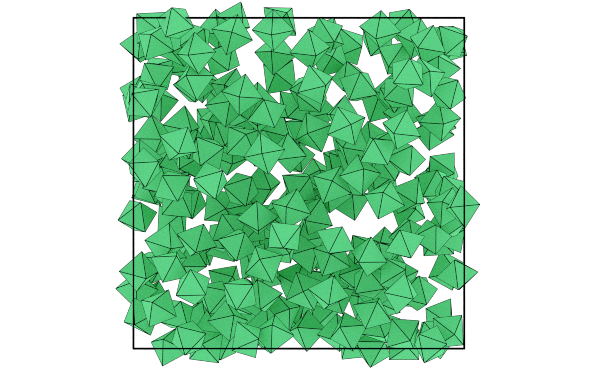

In [6]:
render(sim.state.snapshot)

We will use HPMC to move particles into non-overlapping configurations while we compress the system.
Set up the HPMC integrator for the octahedron simulations:

In [7]:
mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=42)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])
sim.operations.integrator = mc

## The QuickCompress updater

An **Updater** is a type of **operation** in HOOMD-blue that makes changes to the **state**.
To use an **Updater**, we need to instantiate the object, assign a **Trigger**, and add it to the **Simulation**.
**Simulation** will apply the **Updater** on **time steps** where the **Trigger** is `True`.
The most commonly used **Trigger** is **PeriodicTrigger** which executes the **Updater** every `period` steps.

**QuickCompress** is an **Updater** that works with HPMC to quickly compress the box to a target volume.
When triggered, **QuickCompress** reduces the box volume by a scale factor, while *allowing slight overlaps between the particles*.
It then waits for the translation and rotation **trial moves** to remove these overlaps before it reduces the volume again.
This process temporarily produces invalid system configurations, but is much quicker than a process that does not allow temporary overlaps.

Compute the final box size with a **packing fraction** above 0.5 and configure a **QuickCompress** to **trigger** every 10 **time steps**.

In [8]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)
final_packing_fraction = 0.57
final_box.volume = sim.state.snapshot.particles.N * V_particle / final_packing_fraction
# TODO: Implement QuickCompress
# compress = hoomd.hpmc.update.QuickCompress(trigger=hoomd.trigger.Periodic(10), target_box = final_box)

Add the **Updater** to the **Simulation**:

In [9]:
# sim.operations.updaters.append(compress)

## The TrialMoveSize tuner

A **Tuner** is another type of **operation**.
**Tuners** make changes to other **operations** or the system **state** to improve performance.
In HPMC, the translation and rotation trial move sizes have a *huge* performance impact.
When the move size is too small it takes many time steps to make appreciable changes to the system.
When the move size is too large very few moves are accepted and it again takes many time steps to make appreciable changes.
The system makes the most progress at moderate move sizes and, in most cases, the optimal **acceptance ratio** is 20%.
The **TrialMoveSize** tuner monitors the **acceptance ratio** and adjusts `d` and `a` to achieve this target.

The optimal move size depends on the density of the system.
We are changing the density rapidly during compression, so we will use the **TrialMoveSize** tuner to adjust the move sizes regularly:

In [10]:
# TODO: Implement the tuner in the v3 API
# tune = hoomd.hpmc.tune.TrialMoveSize(integrator=mc, tune=['a', 'd'], trigger=hoomd.trigger.Periodic(10))
# sim.operations.tuners.append(tune)

## Run until complete

The **QuickCompress** updater will **complete** the simulation run when it reaches the target box size.
This will stop the run before the requested number of **time steps** is executed.
Run for enough steps to complete the compression:

In [11]:
# TODO: implement this
# sim.run(1e6)

Check to see if the compression completed successfully:

In [12]:
# TODO: implement this
# if not compress.completed:
#     raise RuntimeError("Compression failed to complete")

In [13]:
# This code is not part of the tutorial. 
# It is a temporary Python implementation of QuickCompress method. We will later re-implement in C++ as an Updater and use that here.
D = 2
max_scale = 0.99
max_overlaps = 82*4 / 4
mc.d['octahedron'] = 0.02693819753092484
mc.a['octahedron'] = 0.019871213815167245

import time
import numpy
start_time = time.time()

current_box = hoomd.Box.from_box(initial_box)

N = sim.state.snapshot.particles.N
sim.operations.schedule()

import sys

count = 0

while final_box.volume < current_box.volume:
    
    v = numpy.random.random(1)
    current_scale = v * max_scale + (1-v)*1

    prev_volume = current_box.volume
    current_box.volume = current_scale * current_box.volume

    if current_box.volume < final_box.volume:
        current_box.volume = final_box.volume

    hoomd.update.BoxResize.scale_state(sim.state, current_box)

    overlaps = mc.overlaps

    if overlaps > max_overlaps:
        current_box.volume = prev_volume
        hoomd.update.BoxResize.scale_state(sim.state, current_box)
        overlaps = mc.overlaps
        
        sim.run(10)
       
#     if sim.timestep % 100 == 0:
#         print("phi =", (N*V_particle) / (current_box.volume), ": overlaps =", overlaps);
    
    # run until all overlaps are removed
    while overlaps > 0:
        sim.run(10);
        
        overlaps = mc.overlaps;
        sys.stdout.flush();
        
        gamma = 2.0
        acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
        d_scale = ((1.0 + gamma) * acceptance) / (0.2 + gamma * acceptance)
        mc.d['octahedron'] = mc.d['octahedron'] * d_scale
        max_scale = (3*1 + (1 - mc.d['octahedron']/D)**3)/4

        acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
        a_scale = ((1.0 + gamma) * acceptance) / (0.2 + gamma * acceptance)
        mc.a['octahedron'] = mc.a['octahedron'] * a_scale

#print("phi =", (N*V_particle) / (current_box.volume), ": overlaps =", overlaps);
#end_time = time.time()
#print(end_time - start_time)

*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


Now that the compression is complete, the particles are much closer together and not overlapping, but still arranged randomly.

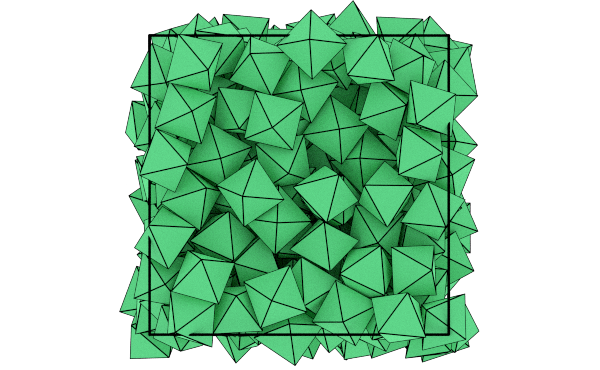

In [14]:
render(sim.state.snapshot)

Let's save the final configuration to a GSD file for use in the next stage of the simulation.

In [15]:
hoomd.dump.GSD.write_state(state=sim.state, filename='compressed.gsd')

[Previous section](04-Randomizing-the-System.ipynb). [Next section](06-Equilibrating-the-System.ipynb).